# Part I - (Dataset Exploration Title)
## by Charles Nikoro

## Introduction

In this document, I will analyze loan data from Prosper (a peear-to-peer lending marketplace) comprising approximately 114000 records with the aim of investigating the possible factors that can affect the outcome of a loan's status.

> Introduce the dataset

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [4]:
# load data and check the first five records
# make sure the dates are correctly parsed

loans = pd.read_csv('../dataset/prosperLoanData.csv', parse_dates=['ListingCreationDate',
    'LoanOriginationDate', 'ClosedDate', 'DateCreditPulled'])

loans.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [5]:
# check the size of the dataset and whether it contains duplicate listings.

print("Shape of the dataframe:", loans.shape)
print("Number of duplicate records:", loans.duplicated().sum())

Shape of the dataframe: (113937, 81)
Number of duplicate records: 0


In [6]:
# columns and their data types

dtypes = ['bool', 'int64', 'float64', 'object']

for dtype in dtypes:
    print(f"{dtype}\n{set(loans.dtypes[loans.dtypes == dtype].index)}\n")

bool
{'IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable'}

int64
{'InvestmentFromFriendsCount', 'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination', 'LoanOriginalAmount', 'ListingNumber', 'LoanNumber', 'ListingCategory (numeric)', 'Term', 'Recommendations', 'OpenRevolvingAccounts', 'Investors'}

float64
{'CreditScoreRangeLower', 'DelinquenciesLast7Years', 'ScorexChangeAtTimeOfListing', 'LP_CustomerPrincipalPayments', 'BankcardUtilization', 'TotalTrades', 'LenderYield', 'BorrowerRate', 'AmountDelinquent', 'PublicRecordsLast12Months', 'LP_InterestandFees', 'PublicRecordsLast10Years', 'RevolvingCreditBalance', 'ProsperScore', 'EstimatedLoss', 'CurrentDelinquencies', 'LoanFirstDefaultedCycleNumber', 'TotalInquiries', 'LP_NonPrincipalRecoverypayments', 'EstimatedReturn', 'ProsperPaymentsOneMonthPlusLate', 'TotalCreditLinespast7years', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'EmploymentStatusDuration', 'ProsperPrincipalBorrowed', 'AvailableBankcardCredit', 'LP_NetPrincip

In [7]:
# make ListingCategory (numeric), ProsperScore and Term of categorical types

def create_category_type(categories, ordered=False):
    """
        Create category type from the list of categories

        Args:
           list: the list of categories
           bool: whether the category type should be ordered. This is False by default

        Returns:
           a pandas CategoricalDtype object.
    """
    return pd.api.types.CategoricalDtype(categories=categories, ordered=ordered)

loans['ListingCategory (numeric)'] = loans['ListingCategory (numeric)'].astype(
    create_category_type(range(21))
)

loans.Term = loans.Term.astype(create_category_type([12,36,60], ordered=True))

# ProsperScore is an ordinal variable

loans.ProsperScore = loans.ProsperScore.astype(create_category_type(categories=range(1,12), ordered=True))

In [8]:
# check values of LoanStatus

loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [53]:
# We won't consider current and cancelled loans in our analysis.

excluded_list = ['Current', 'Cancelled']

loan_sub_data = loans.query('LoanStatus not in @excluded_list').copy()

# the loan status should be categorical. We will also make it ordinal

categories = ['Completed', 'FinalPaymentInProgress',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)', 
'Defaulted', 'Chargedoff']

loan_sub_data.LoanStatus = loan_sub_data.LoanStatus.astype(create_category_type(categories=categories, ordered=True))

# The shape of the subset of data we will be analyzing

print(loan_sub_data.shape)

(57356, 81)


In [54]:
# columns without null values

columns_without_null = loan_sub_data.isna().sum()==0
loan_sub_data.isna().sum()[columns_without_null].index

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'LoanCurrentDaysDelinquent',
       'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount',
       'LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount',
       'Investors'],
      dtype='object')

In [55]:
# columns with null values

columns_with_null = loan_sub_data.isna().sum()>0
loan_sub_data.isna().sum()[columns_with_null].index

Index(['CreditGrade', 'ClosedDate', 'BorrowerAPR', 'EstimatedEffectiveYield',
       'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)',
       'ProsperRating (Alpha)', 'ProsperScore', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'EmploymentStatusDuration', 'GroupKey',
       'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'TotalProsperLoans', 'TotalProsperPaymentsBilled',
       'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate',
       'ProsperPaymentsOne

### What is the structure of your dataset?
The dataset comprises 113937 observations and 81 variables which comprises both qualitative and quantitative variables. Some of them contain null values which means that there are no existing records for the borrower concerned. For instance, according to the [data dictionary](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0), a borrower with a null `TotalProsperLoans` value doesn't have prior loans. The categorical variables includes `ListingCategory (numeric)`, `LoanStatus`, `ProsperScore`, and `Term`. `ListingCategory (numeric)` is encoded as follows: 0 - Not Available, 1 - Debt Consolidation, 2 - Home 
Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic 
Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - 
Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans. `ProsperScore` include values from 1 to 11 with decreasing levels of risk.

### What is/are the main feature(s) of interest in your dataset?

I want to investigate the factors that could affect the outcome of a loan. In particular, I will be considering those that affect complete, default and charged-off loans. Therefore, I won't be considering current or cancelled loans in this analysis. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The original loan amount (`LoanOriginalAmount`) and the principal payments (`LP_CustomerPrincipalPayments`) made by the borrowers are interesting variables to consider. Other variables we would be considering includes: the annual percentage rates (`BorrowerAPR`), the interests and fees paid by borrowers (`LP_InterestandFees`), the term of the loan (`Term`), the number of days the borrower was delinquent on the loan (`LoanCurrentDaysDelinquent`), the stated monthly income (`StatedMonthlyIncome`) and whether they can be verified (`IncomeVerifiable`), the listing category (`ListingCategory (numeric)`), and the total number of prior prosper loans (`TotalProsperLoans`).

## Univariate Exploration

I'll begin by looking at the distribution of the main variable of interest – `LoanStatus`.

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 

##### Which loan status has the highest frequency count?

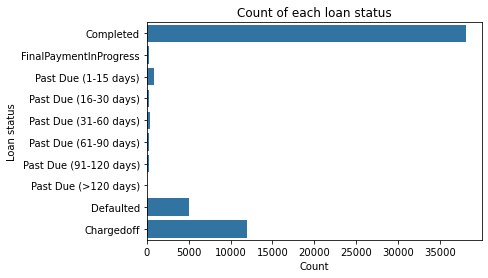

In [56]:
# plot distribution of LoanStatus

sns.countplot(data=loan_sub_data, y='LoanStatus', color=sns.color_palette()[0])
plt.xlabel('Count')
plt.ylabel('Loan status')
plt.title('Count of each loan status')
plt.show();

The above plot shows that most borrowers completed their loans while the least of them are more than 120 days passed due. Next, we will take a look at the distribution of the `StatedMonthlyIncome`.

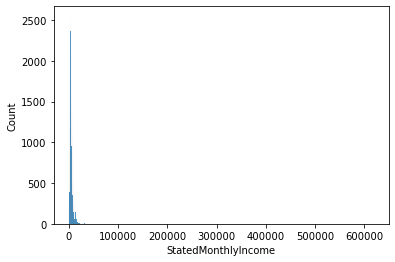

In [57]:
def get_bin_counts(series):
    """
       computes number of bins needed to plot the histogram of series
       using Freedman Diaconis algorithm if the IQR is not 0 else
       take the square root of the number of data points rounded up
       to the nearest integer
       
       :param series: quantitative pandas series
       :return integer: the number of bins
    """
    if series.quantile(0.75) - series.quantile(0.25) != 0:
        bin_width = 2*((series.quantile(0.75)-series.quantile(0.25))/(np.power(series.shape[0],1/3)))
        return ((series.max()-series.min())//bin_width).astype(int)
    return int(math.ceil(math.sqrt(series.shape[0])))

# We will use a histogram to show the distribution of the StatedMonthlyIncome variable

sns.histplot(data=loan_sub_data, x='StatedMonthlyIncome', bins = get_bin_counts(loan_sub_data.StatedMonthlyIncome))
plt.show();

This plot doesn't look that great because `StatedMonthlyIncome` has large values. Let's plot it with a log scale on the x-axis instead. While we are at it, let's also plot the distribution of borrowers with supporting documents to verify their income.

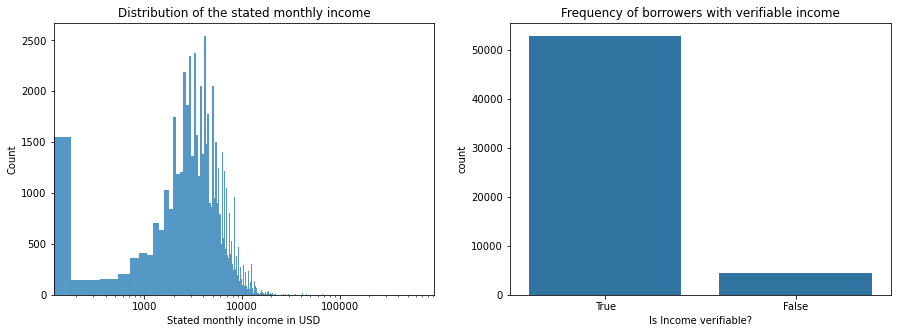

In [58]:
# distribution of log transformation of stated monthly income
# and borrowers with supporting documents for their income.

fig,axs = plt.subplots(1,2,figsize=(15,5))

#xlabels = ['0k', '105k', '210k', '315k', '420k', '525k', '630k']
ax1 = sns.histplot(data=loan_sub_data, x='StatedMonthlyIncome', 
                  bins = get_bin_counts(loan_sub_data.StatedMonthlyIncome), ax=axs[0])

ax1.set_xscale('log')
#x1.set_xticklabels(xlabels)
ax1.get_xaxis().set_major_formatter(ScalarFormatter())

ax1.set(xlabel='Stated monthly income in USD',
        title='Distribution of the stated monthly income')

# distribution of borrowers with verifiable income

ax2 = sns.countplot(data=loan_sub_data, x='IncomeVerifiable', color=sns.color_palette()[0], 
        order=loan_sub_data.IncomeVerifiable.value_counts().index, ax=axs[1])
ax2.set(xlabel="Is Income verifiable?",
        title="Frequency of borrowers with verifiable income")

plt.show();


The distribution of the stated monthly income is slightly right-skewed with a considerable number of borrowers declaring that they earn between $0 and $200. The bar plot on the right shows that most of the borrowers have documents to support their income declaration.

##### What are the distribution of the original loan amount, amount of principal, and the interest and fees paid by the borrowers?

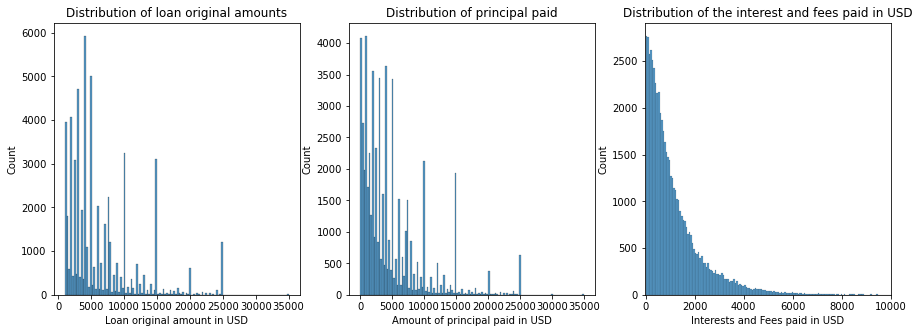

In [77]:
# distribution of the original loan amount

fig, axes = plt.subplots(1,3, figsize=(15,5))

ax1 = sns.histplot(data=loan_sub_data, x='LoanOriginalAmount', 
                  bins=get_bin_counts(loan_sub_data.LoanOriginalAmount), ax=axes[0])

ax1.set(xlabel='Loan original amount in USD',
        title='Distribution of loan original amounts')

# distribution of the amount of principal paid

ax2 = sns.histplot(data=loan_sub_data, x='LP_CustomerPrincipalPayments',
                   bins=get_bin_counts(loan_sub_data.LP_CustomerPayments), ax=axes[1])

ax2.set(xlabel='Amount of principal paid in USD',
        title='Distribution of principal paid')

# distribution of the interest and fees paid

ax3 = sns.histplot(data=loan_sub_data, x='LP_InterestandFees', 
               bins=get_bin_counts(loan_sub_data.LP_InterestandFees), ax=axes[2])

ax3.set_xlim(-50, 10000)

ax3.set(xlabel='Interests and Fees paid in USD',
        title='Distribution of the interest and fees paid in USD')

plt.show();

Both distributions are right skewed with several peaks. This shows that there is a relationship between the original loan amount and the principal paid by the borrowers which is expected. The distribution of the principal paid roughly shows that the number of borrowers that paid a certain principal decreases as the amount increases. This trend is more clearly seen in the distribution of the interest and fees paid. There might be a positive relationship between the amount of principal paid and the interest and fees paid by the borrowers.

##### What is the distribution of the annual percentage rate?

The `BorrowerAPR` variable has some missing values which we can't account for at the moment. Let's see the percentage of null values that it has.

In [60]:
loan_sub_data.BorrowerAPR.isna().sum()/loan_sub_data.BorrowerAPR.shape[0]

0.000435874189274008

As we can see, it is not significant. Therefore, it is okay to replace them with the mean value.

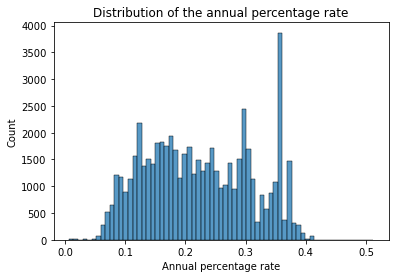

In [78]:
# distribution of the annual percentage rate.
loan_sub_data.BorrowerAPR = loan_sub_data.BorrowerAPR.fillna(loan_sub_data.BorrowerAPR.mean())

ax = sns.histplot(data=loan_sub_data, x='BorrowerAPR', bins=get_bin_counts(loan_sub_data.BorrowerAPR))

ax.set(xlabel='Annual percentage rate',
        title='Distribution of the annual percentage rate')

plt.show();

From the plot, we can see that the distribution of the annual percentage rate is unimodal with the highest peak at around 0.37.

##### What are the distribuions of the total number of prior loans, loan term, and the listing categories?

`Term` and `ListingCategory (numeric)` are both categorical variables so we would explore their distribution on a bar plot. On the other hand, `TotalProsperLoans` is a discrete numeric variable, but because its range of values are relatively small, we can also explore its distribution with a bar plot. This variable also contains null values which means that the borrower had no prior prosper loan. We will replace them with 0.



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

